### Ol-Sense - The Olsen Sister Discriminator

Using the fastai library to build a CNN Olsen sister classifier based on ResNet using a custom data-set. Idea inspired by user [LindyRock](https://forums.fast.ai/u/lindyrock) on the fastai forums. Code adapted from fastai lesson 1.

Trained two models, one based on ResNet34 and another on ResNet50. For both models, after initial training, I unfroze the convolutional layers and used the learning rate finder function to choose an optimal range for cyclic learning rate during training of the entire model.

Both models reached >95% accuracy classifying Elizabeth Olsen, but struggle with the twins, and especially Mary-Kate, for which classification is as good as a coin-toss. This is probably the fault of the naive data collection project, which downloads pictures from Bing Search and center-crops them: predictably, many pictures feature both twins, and there's no standardization to speak of. In many pictures the faces are cropped out as well. A next step for preprocessing will be face detection, leaving out pictures with several faces and cropping pictures appropriately.

#### Data Collection

In [0]:
!pip install icrawler

In [0]:
from icrawler.builtin import (BingImageCrawler, GoogleImageCrawler)
import logging
from fastai.vision import *

In [0]:
path = '/data/mary-kate'
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='mary-kate olsen', filters=None, offset=0, max_num=1000)

In [0]:
path = '/data/ashley'
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='ashley olsen', filters=None, offset=0, max_num=1000)

In [0]:
path = '/data/elizabeth'
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='elizabeth olsen', filters=None, offset=0, max_num=1000)

In [17]:
path = "/data"
classes = ["mary-kate","ashley","elizabeth"]
for c in classes:
    print(c)
    verify_images(path+"/"+c, delete=True, max_size=1000)

mary-kate


tuple index out of range
ashley


Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
elizabeth


In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [22]:
data.classes, len(data.train_ds), len(data.valid_ds), len(os.listdir("/data/mary-kate")),len(os.listdir("/data/ashley")),len(os.listdir("/data/elizabeth"))

(['ashley', 'elizabeth', 'mary-kate'], 1316, 329, 540, 566, 539)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


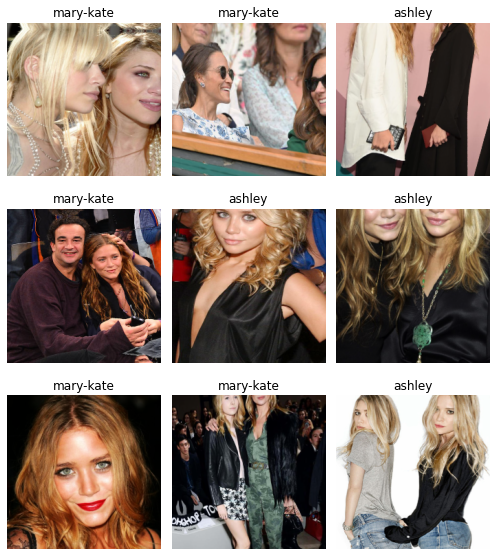

In [23]:
data.show_batch(rows=3, figsize=(7,8))

#### ResNet34

In [24]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [25]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.546071,1.309407,0.434650,00:49
1,1.391945,1.107440,0.389058,00:49
2,1.171777,0.982473,0.379939,00:47
3,1.029836,0.940085,0.395137,00:47


In [0]:
learn.save('stage-1')

Unfreezing ResNet34, using optimal learning rate range

In [0]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


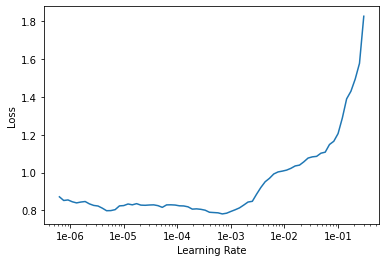

In [30]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.813923,0.927972,0.364742,00:49
1,0.778584,0.886044,0.358663,00:50
2,0.714510,0.854545,0.373860,00:50
3,0.658454,0.851045,0.355623,00:51
4,0.617107,0.850534,0.349544,00:50


In [0]:
learn.save('stage-2')

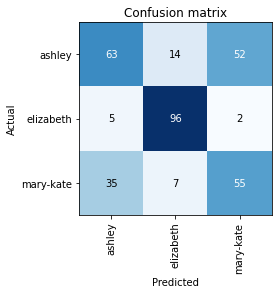

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Resnet50

In [36]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [37]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.632246,1.280322,0.389058,00:51
1,1.376608,1.181131,0.358663,00:51
2,1.134896,0.999218,0.370821,00:51
3,0.926950,0.875474,0.379939,00:51
4,0.801605,0.863867,0.401216,00:51


In [0]:
learn.save("stage-1-50")

Unfreezing ResNet50 and using optimal learning rate range

In [0]:
learn.unfreeze()

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


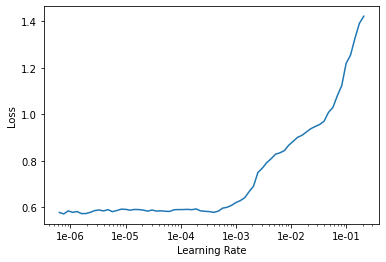

In [41]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.593589,0.817160,0.364742,00:51
1,0.626940,0.922211,0.355623,00:51
2,0.583854,0.846999,0.355623,00:51
3,0.531080,0.857413,0.358663,00:51
4,0.491772,0.849402,0.349544,00:51


ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [0]:
learn.save('stage-2-50')

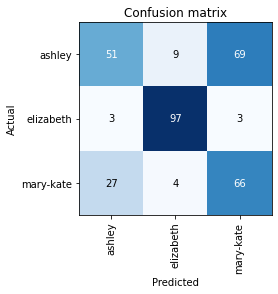

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()